In [1]:
!pip install -r ../requirements.txt

  Attempting uninstall: black
    Found existing installation: black 21.9b0
    Uninstalling black-21.9b0:
      Successfully uninstalled black-21.9b0


You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'deepsig_custom_v2_dft'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Discrete Fourier Transform

Each signal is transformed from an I/Q sample using Discrete Fourier Transform, and added as a column to the dataset.

In [7]:
def I_Q_to_DFT(signal):
    complex_IQ_representation = []
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)
        complex_IQ_representation.append(cmplx)
    
    # numpy fft(arr) transforms an array 'arr' of complex numbers using Discrete Fourier Transform
    ffted_cplx = np.fft.fft(complex_IQ_representation)
    return [ffted_cplx.real, ffted_cplx.imag]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_DFT(signal)
    
    # transformed_signal is a train of values
    transformed_signals.append(transformed_signal)

In [9]:
dft_signals_column_dataframe_name = 'DFT signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[dft_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    dft_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding DFT Signals

In [10]:
dataset_df

,IQ signals,DFT signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[-0.060862621969135944, -0.22769021567320955,...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.07303547981427982, 0.21388404694926202, -0...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.07157310681941453, 0.06983173884925772, -0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.06919694535099552, 0.05751631710576523, -0...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.16920786396804033, 0.3561287889109632, 0.3...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[-0.02215634343883721, 0.11752126689233586, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[-0.10105456630867593, -0.10305432796774971, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[-0.0646182048258197, 0.0054176624689576194, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[-0.16591021459316835, 0.001243809761688204, ...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = dataset_df[dft_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 2, 128)
[2, 128]


In [16]:
model = neural_networks.custom_deepsig_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 36)             9252      
_________________________________________________________________
dense (Dense)                (None, 2, 256)            9472      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 18)             18450     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4864  

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 38:13 - loss: 2.3979

 10/151 [>.............................] - ETA: 0s - loss: 2.3964   

 19/151 [==>...........................] - ETA: 0s - loss: 2.3923

 29/151 [====>.........................] - ETA: 0s - loss: 2.3813

 38/151 [======>.......................] - ETA: 0s - loss: 2.3682

 47/151 [========>.....................] - ETA: 0s - loss: 2.3548

 56/151 [==========>...................] - ETA: 0s - loss: 2.3422

 66/151 [============>.................] - ETA: 0s - loss: 2.3290

 76/151 [==============>...............] - ETA: 0s - loss: 2.3164

 85/151 [===============>..............] - ETA: 0s - loss: 2.3058

 94/151 [=================>............] - ETA: 0s - loss: 2.2956

104/151 [===================>..........] - ETA: 0s - loss: 2.2849

113/151 [=====================>........] - ETA: 0s - loss: 2.2757

122/151 [=======================>......] - ETA: 0s - loss: 2.2669

131/151 [=========================>....] - ETA: 0s - loss: 2.2585

140/151 [==========================>...] - ETA: 0s - loss: 2.2504

149/151 [============================>.] - ETA: 0s - loss: 2.2427

151/151 [==============================] - ETA: 0s - loss: 2.2411

151/151 [==============================] - 17s 10ms/step - loss: 2.2402 - val_loss: 1.9717


Epoch 2/100
  1/151 [..............................] - ETA: 1s - loss: 1.9531

 10/151 [>.............................] - ETA: 0s - loss: 1.9480

 20/151 [==>...........................] - ETA: 0s - loss: 1.9431

 29/151 [====>.........................] - ETA: 0s - loss: 1.9395

 39/151 [======>.......................] - ETA: 0s - loss: 1.9374

 48/151 [========>.....................] - ETA: 0s - loss: 1.9359

 57/151 [==========>...................] - ETA: 0s - loss: 1.9344

 66/151 [============>.................] - ETA: 0s - loss: 1.9327

 76/151 [==============>...............] - ETA: 0s - loss: 1.9307

 86/151 [================>.............] - ETA: 0s - loss: 1.9285

 95/151 [=================>............] - ETA: 0s - loss: 1.9267

105/151 [===================>..........] - ETA: 0s - loss: 1.9246

115/151 [=====================>........] - ETA: 0s - loss: 1.9225

125/151 [=======================>......] - ETA: 0s - loss: 1.9204

135/151 [=========================>....] - ETA: 0s - loss: 1.9184

145/151 [===========================>..] - ETA: 0s - loss: 1.9164

151/151 [==============================] - 1s 7ms/step - loss: 1.9150 - val_loss: 1.8349


Epoch 3/100
  1/151 [..............................] - ETA: 0s - loss: 1.8137

 10/151 [>.............................] - ETA: 0s - loss: 1.8185

 19/151 [==>...........................] - ETA: 0s - loss: 1.8186

 29/151 [====>.........................] - ETA: 0s - loss: 1.8193

 38/151 [======>.......................] - ETA: 0s - loss: 1.8199

 47/151 [========>.....................] - ETA: 0s - loss: 1.8200



 56/151 [==========>...................] - ETA: 0s - loss: 1.8195

 65/151 [===========>..................] - ETA: 0s - loss: 1.8190

 74/151 [=============>................] - ETA: 0s - loss: 1.8184

 83/151 [===============>..............] - ETA: 0s - loss: 1.8177

 93/151 [=================>............] - ETA: 0s - loss: 1.8168

102/151 [===================>..........] - ETA: 0s - loss: 1.8160

111/151 [=====================>........] - ETA: 0s - loss: 1.8152

120/151 [======================>.......] - ETA: 0s - loss: 1.8143

129/151 [========================>.....] - ETA: 0s - loss: 1.8134

138/151 [==========================>...] - ETA: 0s - loss: 1.8126

147/151 [============================>.] - ETA: 0s - loss: 1.8117

151/151 [==============================] - 1s 7ms/step - loss: 1.8113 - val_loss: 1.7823


Epoch 4/100


  1/151 [..............................] - ETA: 1s - loss: 1.7711

  9/151 [>.............................] - ETA: 0s - loss: 1.7543

 18/151 [==>...........................] - ETA: 0s - loss: 1.7560

 27/151 [====>.........................] - ETA: 0s - loss: 1.7570

 36/151 [======>.......................] - ETA: 0s - loss: 1.7572

 45/151 [=======>......................] - ETA: 0s - loss: 1.7573

 54/151 [=========>....................] - ETA: 0s - loss: 1.7569

 63/151 [===========>..................] - ETA: 0s - loss: 1.7569

 72/151 [=============>................] - ETA: 0s - loss: 1.7569

 81/151 [===============>..............] - ETA: 0s - loss: 1.7568

 90/151 [================>.............] - ETA: 0s - loss: 1.7565

 99/151 [==================>...........] - ETA: 0s - loss: 1.7561



108/151 [====================>.........] - ETA: 0s - loss: 1.7558

117/151 [======================>.......] - ETA: 0s - loss: 1.7554

126/151 [========================>.....] - ETA: 0s - loss: 1.7549

135/151 [=========================>....] - ETA: 0s - loss: 1.7545

145/151 [===========================>..] - ETA: 0s - loss: 1.7541

151/151 [==============================] - 1s 7ms/step - loss: 1.7537 - val_loss: 1.7379


Epoch 5/100
  1/151 [..............................] - ETA: 1s - loss: 1.7136

 10/151 [>.............................] - ETA: 0s - loss: 1.7277

 19/151 [==>...........................] - ETA: 0s - loss: 1.7256

 28/151 [====>.........................] - ETA: 0s - loss: 1.7239

 37/151 [======>.......................] - ETA: 0s - loss: 1.7220

 47/151 [========>.....................] - ETA: 0s - loss: 1.7198

 57/151 [==========>...................] - ETA: 0s - loss: 1.7183

 66/151 [============>.................] - ETA: 0s - loss: 1.7174

 76/151 [==============>...............] - ETA: 0s - loss: 1.7164

 86/151 [================>.............] - ETA: 0s - loss: 1.7157

 95/151 [=================>............] - ETA: 0s - loss: 1.7151

104/151 [===================>..........] - ETA: 0s - loss: 1.7143

113/151 [=====================>........] - ETA: 0s - loss: 1.7136

122/151 [=======================>......] - ETA: 0s - loss: 1.7128

131/151 [=========================>....] - ETA: 0s - loss: 1.7121



140/151 [==========================>...] - ETA: 0s - loss: 1.7114

149/151 [============================>.] - ETA: 0s - loss: 1.7108

151/151 [==============================] - 1s 7ms/step - loss: 1.7106 - val_loss: 1.7002


Epoch 6/100
  1/151 [..............................] - ETA: 0s - loss: 1.6909

 10/151 [>.............................] - ETA: 0s - loss: 1.6761

 19/151 [==>...........................] - ETA: 0s - loss: 1.6730

 29/151 [====>.........................] - ETA: 0s - loss: 1.6727

 38/151 [======>.......................] - ETA: 0s - loss: 1.6726

 47/151 [========>.....................] - ETA: 0s - loss: 1.6722

 56/151 [==========>...................] - ETA: 0s - loss: 1.6718

 65/151 [===========>..................] - ETA: 0s - loss: 1.6717



 74/151 [=============>................] - ETA: 0s - loss: 1.6714

 84/151 [===============>..............] - ETA: 0s - loss: 1.6710

 93/151 [=================>............] - ETA: 0s - loss: 1.6707

102/151 [===================>..........] - ETA: 0s - loss: 1.6704

111/151 [=====================>........] - ETA: 0s - loss: 1.6700

120/151 [======================>.......] - ETA: 0s - loss: 1.6695

130/151 [========================>.....] - ETA: 0s - loss: 1.6690

140/151 [==========================>...] - ETA: 0s - loss: 1.6686

150/151 [============================>.] - ETA: 0s - loss: 1.6683

151/151 [==============================] - 1s 7ms/step - loss: 1.6682 - val_loss: 1.6756


Epoch 7/100
  1/151 [..............................] - ETA: 0s - loss: 1.6229

 10/151 [>.............................] - ETA: 0s - loss: 1.6278

 19/151 [==>...........................] - ETA: 0s - loss: 1.6308

 28/151 [====>.........................] - ETA: 0s - loss: 1.6330

 37/151 [======>.......................] - ETA: 0s - loss: 1.6342

 46/151 [========>.....................] - ETA: 0s - loss: 1.6351



 55/151 [=========>....................] - ETA: 0s - loss: 1.6352

 64/151 [===========>..................] - ETA: 0s - loss: 1.6353

 73/151 [=============>................] - ETA: 0s - loss: 1.6355

 82/151 [===============>..............] - ETA: 0s - loss: 1.6357

 91/151 [=================>............] - ETA: 0s - loss: 1.6358



100/151 [==================>...........] - ETA: 0s - loss: 1.6358

109/151 [====================>.........] - ETA: 0s - loss: 1.6359

118/151 [======================>.......] - ETA: 0s - loss: 1.6361

128/151 [========================>.....] - ETA: 0s - loss: 1.6361

137/151 [==========================>...] - ETA: 0s - loss: 1.6362

146/151 [============================>.] - ETA: 0s - loss: 1.6363

151/151 [==============================] - 1s 7ms/step - loss: 1.6363 - val_loss: 1.6592


Epoch 8/100
  1/151 [..............................] - ETA: 1s - loss: 1.5947

 10/151 [>.............................] - ETA: 0s - loss: 1.6034

 19/151 [==>...........................] - ETA: 0s - loss: 1.6089

 28/151 [====>.........................] - ETA: 0s - loss: 1.6113

 37/151 [======>.......................] - ETA: 0s - loss: 1.6123

 46/151 [========>.....................] - ETA: 0s - loss: 1.6128

 55/151 [=========>....................] - ETA: 0s - loss: 1.6131

 64/151 [===========>..................] - ETA: 0s - loss: 1.6136

 73/151 [=============>................] - ETA: 0s - loss: 1.6138

 82/151 [===============>..............] - ETA: 0s - loss: 1.6138

 91/151 [=================>............] - ETA: 0s - loss: 1.6136

100/151 [==================>...........] - ETA: 0s - loss: 1.6135

109/151 [====================>.........] - ETA: 0s - loss: 1.6135



118/151 [======================>.......] - ETA: 0s - loss: 1.6134

127/151 [========================>.....] - ETA: 0s - loss: 1.6133

136/151 [==========================>...] - ETA: 0s - loss: 1.6133

145/151 [===========================>..] - ETA: 0s - loss: 1.6132

151/151 [==============================] - 1s 7ms/step - loss: 1.6131 - val_loss: 1.6363


Epoch 9/100
  1/151 [..............................] - ETA: 1s - loss: 1.5786

 10/151 [>.............................] - ETA: 0s - loss: 1.5938

 19/151 [==>...........................] - ETA: 0s - loss: 1.5913

 28/151 [====>.........................] - ETA: 0s - loss: 1.5914

 37/151 [======>.......................] - ETA: 0s - loss: 1.5918

 46/151 [========>.....................] - ETA: 0s - loss: 1.5925

 55/151 [=========>....................] - ETA: 0s - loss: 1.5927

 64/151 [===========>..................] - ETA: 0s - loss: 1.5928

 73/151 [=============>................] - ETA: 0s - loss: 1.5930

 82/151 [===============>..............] - ETA: 0s - loss: 1.5931

 91/151 [=================>............] - ETA: 0s - loss: 1.5931

100/151 [==================>...........] - ETA: 0s - loss: 1.5930

109/151 [====================>.........] - ETA: 0s - loss: 1.5928

118/151 [======================>.......] - ETA: 0s - loss: 1.5926

127/151 [========================>.....] - ETA: 0s - loss: 1.5925

136/151 [==========================>...] - ETA: 0s - loss: 1.5923

145/151 [===========================>..] - ETA: 0s - loss: 1.5922

151/151 [==============================] - 1s 7ms/step - loss: 1.5920 - val_loss: 1.6205


Epoch 10/100
  1/151 [..............................] - ETA: 1s - loss: 1.5472

 10/151 [>.............................] - ETA: 0s - loss: 1.5629

 19/151 [==>...........................] - ETA: 0s - loss: 1.5669

 28/151 [====>.........................] - ETA: 0s - loss: 1.5688

 37/151 [======>.......................] - ETA: 0s - loss: 1.5699

 46/151 [========>.....................] - ETA: 0s - loss: 1.5699

 55/151 [=========>....................] - ETA: 0s - loss: 1.5696

 64/151 [===========>..................] - ETA: 0s - loss: 1.5693

 73/151 [=============>................] - ETA: 0s - loss: 1.5692

 82/151 [===============>..............] - ETA: 0s - loss: 1.5691

 92/151 [=================>............] - ETA: 0s - loss: 1.5692

101/151 [===================>..........] - ETA: 0s - loss: 1.5691

110/151 [====================>.........] - ETA: 0s - loss: 1.5691

119/151 [======================>.......] - ETA: 0s - loss: 1.5691

128/151 [========================>.....] - ETA: 0s - loss: 1.5692

137/151 [==========================>...] - ETA: 0s - loss: 1.5693

146/151 [============================>.] - ETA: 0s - loss: 1.5694

151/151 [==============================] - 1s 7ms/step - loss: 1.5694 - val_loss: 1.6078


Epoch 11/100
  1/151 [..............................] - ETA: 0s - loss: 1.5122

 10/151 [>.............................] - ETA: 0s - loss: 1.5347

 19/151 [==>...........................] - ETA: 0s - loss: 1.5399

 28/151 [====>.........................] - ETA: 0s - loss: 1.5431

 37/151 [======>.......................] - ETA: 0s - loss: 1.5449

 46/151 [========>.....................] - ETA: 0s - loss: 1.5459

 55/151 [=========>....................] - ETA: 0s - loss: 1.5466

 64/151 [===========>..................] - ETA: 0s - loss: 1.5471

 74/151 [=============>................] - ETA: 0s - loss: 1.5478

 83/151 [===============>..............] - ETA: 0s - loss: 1.5481

 92/151 [=================>............] - ETA: 0s - loss: 1.5484

101/151 [===================>..........] - ETA: 0s - loss: 1.5488

110/151 [====================>.........] - ETA: 0s - loss: 1.5491

119/151 [======================>.......] - ETA: 0s - loss: 1.5494

128/151 [========================>.....] - ETA: 0s - loss: 1.5497

137/151 [==========================>...] - ETA: 0s - loss: 1.5499

146/151 [============================>.] - ETA: 0s - loss: 1.5501

151/151 [==============================] - 1s 7ms/step - loss: 1.5502 - val_loss: 1.6047


Epoch 12/100
  1/151 [..............................] - ETA: 1s - loss: 1.5359

 10/151 [>.............................] - ETA: 0s - loss: 1.5553

 19/151 [==>...........................] - ETA: 0s - loss: 1.5537

 28/151 [====>.........................] - ETA: 0s - loss: 1.5520

 37/151 [======>.......................] - ETA: 0s - loss: 1.5504

 46/151 [========>.....................] - ETA: 0s - loss: 1.5492

 55/151 [=========>....................] - ETA: 0s - loss: 1.5483

 64/151 [===========>..................] - ETA: 0s - loss: 1.5476

 73/151 [=============>................] - ETA: 0s - loss: 1.5469

 82/151 [===============>..............] - ETA: 0s - loss: 1.5461

 91/151 [=================>............] - ETA: 0s - loss: 1.5456

100/151 [==================>...........] - ETA: 0s - loss: 1.5452

109/151 [====================>.........] - ETA: 0s - loss: 1.5449

118/151 [======================>.......] - ETA: 0s - loss: 1.5448

127/151 [========================>.....] - ETA: 0s - loss: 1.5447

136/151 [==========================>...] - ETA: 0s - loss: 1.5446

145/151 [===========================>..] - ETA: 0s - loss: 1.5445

151/151 [==============================] - 1s 7ms/step - loss: 1.5444 - val_loss: 1.5863


Epoch 13/100
  1/151 [..............................] - ETA: 1s - loss: 1.4909

 10/151 [>.............................] - ETA: 0s - loss: 1.5114

 19/151 [==>...........................] - ETA: 0s - loss: 1.5148

 28/151 [====>.........................] - ETA: 0s - loss: 1.5171

 37/151 [======>.......................] - ETA: 0s - loss: 1.5182

 46/151 [========>.....................] - ETA: 0s - loss: 1.5188

 55/151 [=========>....................] - ETA: 0s - loss: 1.5198

 64/151 [===========>..................] - ETA: 0s - loss: 1.5207

 73/151 [=============>................] - ETA: 0s - loss: 1.5212

 82/151 [===============>..............] - ETA: 0s - loss: 1.5218

 91/151 [=================>............] - ETA: 0s - loss: 1.5223

100/151 [==================>...........] - ETA: 0s - loss: 1.5229



109/151 [====================>.........] - ETA: 0s - loss: 1.5234

118/151 [======================>.......] - ETA: 0s - loss: 1.5239

127/151 [========================>.....] - ETA: 0s - loss: 1.5243

136/151 [==========================>...] - ETA: 0s - loss: 1.5245

145/151 [===========================>..] - ETA: 0s - loss: 1.5247

151/151 [==============================] - 1s 7ms/step - loss: 1.5249 - val_loss: 1.5715


Epoch 14/100
  1/151 [..............................] - ETA: 1s - loss: 1.4922

 10/151 [>.............................] - ETA: 0s - loss: 1.5086

 19/151 [==>...........................] - ETA: 0s - loss: 1.5090

 28/151 [====>.........................] - ETA: 0s - loss: 1.5117

 37/151 [======>.......................] - ETA: 0s - loss: 1.5123

 46/151 [========>.....................] - ETA: 0s - loss: 1.5126

 55/151 [=========>....................] - ETA: 0s - loss: 1.5126

 64/151 [===========>..................] - ETA: 0s - loss: 1.5128

 73/151 [=============>................] - ETA: 0s - loss: 1.5133

 82/151 [===============>..............] - ETA: 0s - loss: 1.5138

 91/151 [=================>............] - ETA: 0s - loss: 1.5143

100/151 [==================>...........] - ETA: 0s - loss: 1.5147

109/151 [====================>.........] - ETA: 0s - loss: 1.5150

118/151 [======================>.......] - ETA: 0s - loss: 1.5153

127/151 [========================>.....] - ETA: 0s - loss: 1.5155

136/151 [==========================>...] - ETA: 0s - loss: 1.5157

145/151 [===========================>..] - ETA: 0s - loss: 1.5159

151/151 [==============================] - 1s 7ms/step - loss: 1.5160 - val_loss: 1.5700


Epoch 15/100
  1/151 [..............................] - ETA: 1s - loss: 1.5337

 10/151 [>.............................] - ETA: 0s - loss: 1.5285

 19/151 [==>...........................] - ETA: 0s - loss: 1.5177

 28/151 [====>.........................] - ETA: 0s - loss: 1.5128

 37/151 [======>.......................] - ETA: 0s - loss: 1.5099

 46/151 [========>.....................] - ETA: 0s - loss: 1.5082

 55/151 [=========>....................] - ETA: 0s - loss: 1.5077

 64/151 [===========>..................] - ETA: 0s - loss: 1.5072

 73/151 [=============>................] - ETA: 0s - loss: 1.5067

 82/151 [===============>..............] - ETA: 0s - loss: 1.5064

 91/151 [=================>............] - ETA: 0s - loss: 1.5061

100/151 [==================>...........] - ETA: 0s - loss: 1.5059

109/151 [====================>.........] - ETA: 0s - loss: 1.5059

118/151 [======================>.......] - ETA: 0s - loss: 1.5058

127/151 [========================>.....]

 - ETA: 0s - loss: 1.5058



136/151 [==========================>...] - ETA: 0s - loss: 1.5058

145/151 [===========================>..] - ETA: 0s - loss: 1.5058

151/151 [==============================] - 1s 7ms/step - loss: 1.5057 - val_loss: 1.5605


Epoch 16/100
  1/151 [..............................] - ETA: 1s - loss: 1.4997

 10/151 [>.............................] - ETA: 0s - loss: 1.4823

 19/151 [==>...........................] - ETA: 0s - loss: 1.4819

 29/151 [====>.........................] - ETA: 0s - loss: 1.4825

 38/151 [======>.......................] - ETA: 0s - loss: 1.4835

 47/151 [========>.....................] - ETA: 0s - loss: 1.4845

 56/151 [==========>...................] - ETA: 0s - loss: 1.4848

 65/151 [===========>..................] - ETA: 0s - loss: 1.4847

 74/151 [=============>................] - ETA: 0s - loss: 1.4848

 83/151 [===============>..............] - ETA: 0s - loss: 1.4850

 92/151 [=================>............] - ETA: 0s - loss: 1.4853

101/151 [===================>..........] - ETA: 0s - loss: 1.4856

110/151 [====================>.........] - ETA: 0s - loss: 1.4861

119/151 [======================>.......] - ETA: 0s - loss: 1.4866

128/151 [========================>.....] - ETA: 0s - loss: 1.4870



137/151 [==========================>...] - ETA: 0s - loss: 1.4874

146/151 [============================>.] - ETA: 0s - loss: 1.4877

151/151 [==============================] - 1s 7ms/step - loss: 1.4879 - val_loss: 1.5523


Epoch 17/100
  1/151 [..............................] - ETA: 1s - loss: 1.4930

 10/151 [>.............................] - ETA: 0s - loss: 1.4909

 19/151 [==>...........................] - ETA: 0s - loss: 1.4879

 28/151 [====>.........................] - ETA: 0s - loss: 1.4870

 37/151 [======>.......................] - ETA: 0s - loss: 1.4859

 46/151 [========>.....................] - ETA: 0s - loss: 1.4849

 55/151 [=========>....................] - ETA: 0s - loss: 1.4841

 64/151 [===========>..................] - ETA: 0s - loss: 1.4837

 73/151 [=============>................] - ETA: 0s - loss: 1.4836

 82/151 [===============>..............] - ETA: 0s - loss: 1.4837

 91/151 [=================>............] - ETA: 0s - loss: 1.4839

100/151 [==================>...........] - ETA: 0s - loss: 1.4841

109/151 [====================>.........] - ETA: 0s - loss: 1.4843

118/151 [======================>.......] - ETA: 0s - loss: 1.4844

127/151 [========================>.....] - ETA: 0s - loss: 1.4845

136/151 [==========================>...] - ETA: 0s - loss: 1.4845

145/151 [===========================>..] - ETA: 0s - loss: 1.4845

151/151 [==============================] - 1s 7ms/step - loss: 1.4845 - val_loss: 1.5443


Epoch 18/100
  1/151 [..............................] - ETA: 1s - loss: 1.4596

 10/151 [>.............................] - ETA: 0s - loss: 1.4546

 19/151 [==>...........................] - ETA: 0s - loss: 1.4615

 28/151 [====>.........................] - ETA: 0s - loss: 1.4660

 37/151 [======>.......................] - ETA: 0s - loss: 1.4682

 46/151 [========>.....................] - ETA: 0s - loss: 1.4690

 55/151 [=========>....................] - ETA: 0s - loss: 1.4693

 64/151 [===========>..................] - ETA: 0s - loss: 1.4694

 73/151 [=============>................] - ETA: 0s - loss: 1.4696

 82/151 [===============>..............] - ETA: 0s - loss: 1.4700

 91/151 [=================>............] - ETA: 0s - loss: 1.4704

100/151 [==================>...........] - ETA: 0s - loss: 1.4706

109/151 [====================>.........] - ETA: 0s - loss: 1.4709

118/151 [======================>.......] - ETA: 0s - loss: 1.4710

127/151 [========================>.....] - ETA: 0s - loss: 1.4711



136/151 [==========================>...] - ETA: 0s - loss: 1.4712

145/151 [===========================>..] - ETA: 0s - loss: 1.4713

151/151 [==============================] - 1s 7ms/step - loss: 1.4714 - val_loss: 1.5380


Epoch 19/100
  1/151 [..............................] - ETA: 1s - loss: 1.4297

 10/151 [>.............................] - ETA: 0s - loss: 1.4364

 19/151 [==>...........................] - ETA: 0s - loss: 1.4396

 28/151 [====>.........................] - ETA: 0s - loss: 1.4445

 37/151 [======>.......................] - ETA: 0s - loss: 1.4475

 46/151 [========>.....................] - ETA: 0s - loss: 1.4492

 55/151 [=========>....................] - ETA: 0s - loss: 1.4505

 64/151 [===========>..................] - ETA: 0s - loss: 1.4516

 73/151 [=============>................] - ETA: 0s - loss: 1.4525

 83/151 [===============>..............] - ETA: 0s - loss: 1.4533

 92/151 [=================>............] - ETA: 0s - loss: 1.4540

101/151 [===================>..........] - ETA: 0s - loss: 1.4547

110/151 [====================>.........] - ETA: 0s - loss: 1.4552

119/151 [======================>.......] - ETA: 0s - loss: 1.4556

128/151 [========================>.....] - ETA: 0s - loss: 1.4560

137/151 [==========================>...] - ETA: 0s - loss: 1.4563

146/151 [============================>.] - ETA: 0s - loss: 1.4567

151/151 [==============================] - 1s 7ms/step - loss: 1.4569 - val_loss: 1.5337


Epoch 20/100
  1/151 [..............................] - ETA: 0s - loss: 1.4114

 10/151 [>.............................] - ETA: 0s - loss: 1.4255

 19/151 [==>...........................] - ETA: 0s - loss: 1.4309

 28/151 [====>.........................] - ETA: 0s - loss: 1.4346

 37/151 [======>.......................] - ETA: 0s - loss: 1.4377

 46/151 [========>.....................] - ETA: 0s - loss: 1.4399

 55/151 [=========>....................] - ETA: 0s - loss: 1.4411

 64/151 [===========>..................] - ETA: 0s - loss: 1.4422

 73/151 [=============>................] - ETA: 0s - loss: 1.4430

 82/151 [===============>..............] - ETA: 0s - loss: 1.4436

 91/151 [=================>............] - ETA: 0s - loss: 1.4441

100/151 [==================>...........] - ETA: 0s - loss: 1.4446

109/151 [====================>.........] - ETA: 0s - loss: 1.4449



118/151 [======================>.......] - ETA: 0s - loss: 1.4452

127/151 [========================>.....] - ETA: 0s - loss: 1.4456

136/151 [==========================>...] - ETA: 0s - loss: 1.4460

145/151 [===========================>..] - ETA: 0s - loss: 1.4464

151/151 [==============================] - 1s 7ms/step - loss: 1.4466 - val_loss: 1.5250


Epoch 21/100
  1/151 [..............................] - ETA: 1s - loss: 1.5033

 10/151 [>.............................] - ETA: 0s - loss: 1.4393

 19/151 [==>...........................] - ETA: 0s - loss: 1.4337

 28/151 [====>.........................] - ETA: 0s - loss: 1.4346

 37/151 [======>.......................] - ETA: 0s - loss: 1.4355

 46/151 [========>.....................] - ETA: 0s - loss: 1.4367

 55/151 [=========>....................] - ETA: 0s - loss: 1.4378

 64/151 [===========>..................] - ETA: 0s - loss: 1.4388

 73/151 [=============>................] - ETA: 0s - loss: 1.4394

 82/151 [===============>..............] - ETA: 0s - loss: 1.4396

 91/151 [=================>............] - ETA: 0s - loss: 1.4399

100/151 [==================>...........] - ETA: 0s - loss: 1.4401

109/151 [====================>.........] - ETA: 0s - loss: 1.4401

118/151 [======================>.......] - ETA: 0s - loss: 1.4403

128/151 [========================>.....] - ETA: 0s - loss: 1.4406

137/151 [==========================>...] - ETA: 0s - loss: 1.4409

146/151 [============================>.] - ETA: 0s - loss: 1.4412

151/151 [==============================] - 1s 7ms/step - loss: 1.4414 - val_loss: 1.5213


Epoch 22/100
  1/151 [..............................] - ETA: 1s - loss: 1.4376

 10/151 [>.............................] - ETA: 0s - loss: 1.4466

 19/151 [==>...........................] - ETA: 0s - loss: 1.4409

 28/151 [====>.........................] - ETA: 0s - loss: 1.4382



 38/151 [======>.......................] - ETA: 0s - loss: 1.4357

 47/151 [========>.....................] - ETA: 0s - loss: 1.4341

 56/151 [==========>...................] - ETA: 0s - loss: 1.4329

 65/151 [===========>..................] - ETA: 0s - loss: 1.4321

 74/151 [=============>................] - ETA: 0s - loss: 1.4318



 83/151 [===============>..............] - ETA: 0s - loss: 1.4316

 92/151 [=================>............] - ETA: 0s - loss: 1.4315

101/151 [===================>..........] - ETA: 0s - loss: 1.4315



110/151 [====================>.........] - ETA: 0s - loss: 1.4316

119/151 [======================>.......] - ETA: 0s - loss: 1.4317

128/151 [========================>.....] - ETA: 0s - loss: 1.4319



137/151 [==========================>...] - ETA: 0s - loss: 1.4320

146/151 [============================>.] - ETA: 0s - loss: 1.4320

151/151 [==============================] - 1s 7ms/step - loss: 1.4321 - val_loss: 1.5144


Epoch 23/100
  1/151 [..............................] - ETA: 1s - loss: 1.3851

 10/151 [>.............................] - ETA: 0s - loss: 1.4154

 19/151 [==>...........................] - ETA: 0s - loss: 1.4177

 28/151 [====>.........................] - ETA: 0s - loss: 1.4192

 37/151 [======>.......................] - ETA: 0s - loss: 1.4205

 46/151 [========>.....................] - ETA: 0s - loss: 1.4206

 55/151 [=========>....................] - ETA: 0s - loss: 1.4211

 64/151 [===========>..................] - ETA: 0s - loss: 1.4216

 73/151 [=============>................] - ETA: 0s - loss: 1.4220

 82/151 [===============>..............] - ETA: 0s - loss: 1.4224

 91/151 [=================>............] - ETA: 0s - loss: 1.4226



100/151 [==================>...........] - ETA: 0s - loss: 1.4228

109/151 [====================>.........] - ETA: 0s - loss: 1.4230

118/151 [======================>.......] - ETA: 0s - loss: 1.4232

127/151 [========================>.....] - ETA: 0s - loss: 1.4233

136/151 [==========================>...] - ETA: 0s - loss: 1.4235

145/151 [===========================>..] - ETA: 0s - loss: 1.4236

151/151 [==============================] - 1s 7ms/step - loss: 1.4237 - val_loss: 1.5286


Epoch 24/100
  1/151 [..............................] - ETA: 0s - loss: 1.4081

 10/151 [>.............................] - ETA: 0s - loss: 1.4037

 19/151 [==>...........................] - ETA: 0s - loss: 1.4037

 28/151 [====>.........................] - ETA: 0s - loss: 1.4035

 37/151 [======>.......................] - ETA: 0s - loss: 1.4038

 46/151 [========>.....................] - ETA: 0s - loss: 1.4042

 55/151 [=========>....................] - ETA: 0s - loss: 1.4046

 64/151 [===========>..................] - ETA: 0s - loss: 1.4051

 73/151 [=============>................] - ETA: 0s - loss: 1.4057

 82/151 [===============>..............] - ETA: 0s - loss: 1.4064

 91/151 [=================>............] - ETA: 0s - loss: 1.4070

100/151 [==================>...........] - ETA: 0s - loss: 1.4076

109/151 [====================>.........] - ETA: 0s - loss: 1.4082

118/151 [======================>.......] - ETA: 0s - loss: 1.4087

127/151 [========================>.....] - ETA: 0s - loss: 1.4093

136/151 [==========================>...] - ETA: 0s - loss: 1.4098

145/151 [===========================>..] - ETA: 0s - loss: 1.4102

151/151 [==============================] - 1s 7ms/step - loss: 1.4105 - val_loss: 1.5043


Epoch 25/100
  1/151 [..............................] - ETA: 1s - loss: 1.4011

 10/151 [>.............................] - ETA: 0s - loss: 1.3910

 19/151 [==>...........................] - ETA: 0s - loss: 1.3892

 28/151 [====>.........................] - ETA: 0s - loss: 1.3922

 37/151 [======>.......................] - ETA: 0s - loss: 1.3941

 46/151 [========>.....................] - ETA: 0s - loss: 1.3954

 55/151 [=========>....................] - ETA: 0s - loss: 1.3966

 64/151 [===========>..................] - ETA: 0s - loss: 1.3974

 73/151 [=============>................] - ETA: 0s - loss: 1.3979

 82/151 [===============>..............] - ETA: 0s - loss: 1.3985

 91/151 [=================>............] - ETA: 0s - loss: 1.3992

100/151 [==================>...........] - ETA: 0s - loss: 1.3998

109/151 [====================>.........] - ETA: 0s - loss: 1.4005

118/151 [======================>.......] - ETA: 0s - loss: 1.4011

127/151 [========================>.....] - ETA: 0s - loss: 1.4017

136/151 [==========================>...] - ETA: 0s - loss: 1.4022

145/151 [===========================>..] - ETA: 0s - loss: 1.4027

151/151 [==============================] - 1s 7ms/step - loss: 1.4030 - val_loss: 1.5005


Epoch 26/100
  1/151 [..............................] - ETA: 1s - loss: 1.3741

 10/151 [>.............................] - ETA: 0s - loss: 1.3896

 20/151 [==>...........................] - ETA: 0s - loss: 1.3873

 29/151 [====>.........................] - ETA: 0s - loss: 1.3876

 38/151 [======>.......................] - ETA: 0s - loss: 1.3890

 47/151 [========>.....................] - ETA: 0s - loss: 1.3901

 57/151 [==========>...................] - ETA: 0s - loss: 1.3911

 66/151 [============>.................] - ETA: 0s - loss: 1.3918

 75/151 [=============>................] - ETA: 0s - loss: 1.3923

 84/151 [===============>..............] - ETA: 0s - loss: 1.3926

 93/151 [=================>............] - ETA: 0s - loss: 1.3929

102/151 [===================>..........] - ETA: 0s - loss: 1.3931



111/151 [=====================>........] - ETA: 0s - loss: 1.3933

120/151 [======================>.......] - ETA: 0s - loss: 1.3936

129/151 [========================>.....] - ETA: 0s - loss: 1.3939

138/151 [==========================>...] - ETA: 0s - loss: 1.3941

147/151 [============================>.] - ETA: 0s - loss: 1.3944

151/151 [==============================] - 1s 7ms/step - loss: 1.3946 - val_loss: 1.4982


Epoch 27/100
  1/151 [..............................] - ETA: 1s - loss: 1.3660

  9/151 [>.............................] - ETA: 0s - loss: 1.3764

 18/151 [==>...........................] - ETA: 0s - loss: 1.3782

 27/151 [====>.........................] - ETA: 0s - loss: 1.3796

 36/151 [======>.......................] - ETA: 0s - loss: 1.3818

 45/151 [=======>......................] - ETA: 0s - loss: 1.3827

 55/151 [=========>....................] - ETA: 0s - loss: 1.3836

 64/151 [===========>..................] - ETA: 0s - loss: 1.3843

 73/151 [=============>................] - ETA: 0s - loss: 1.3849

 82/151 [===============>..............] - ETA: 0s - loss: 1.3853



 91/151 [=================>............] - ETA: 0s - loss: 1.3855

100/151 [==================>...........] - ETA: 0s - loss: 1.3858

109/151 [====================>.........] - ETA: 0s - loss: 1.3861

118/151 [======================>.......] - ETA: 0s - loss: 1.3865

127/151 [========================>.....] - ETA: 0s - loss: 1.3869

136/151 [==========================>...] - ETA: 0s - loss: 1.3873

145/151 [===========================>..] - ETA: 0s - loss: 1.3876

151/151 [==============================] - 1s 7ms/step - loss: 1.3879 - val_loss: 1.4892


Epoch 28/100
  1/151 [..............................] - ETA: 0s - loss: 1.3682

 10/151 [>.............................] - ETA: 0s - loss: 1.3962

 19/151 [==>...........................] - ETA: 0s - loss: 1.3992

 28/151 [====>.........................] - ETA: 0s - loss: 1.3982

 37/151 [======>.......................] - ETA: 0s - loss: 1.3971

 46/151 [========>.....................] - ETA: 0s - loss: 1.3953

 55/151 [=========>....................] - ETA: 0s - loss: 1.3937

 64/151 [===========>..................] - ETA: 0s - loss: 1.3925

 73/151 [=============>................] - ETA: 0s - loss: 1.3913

 82/151 [===============>..............] - ETA: 0s - loss: 1.3905

 91/151 [=================>............] - ETA: 0s - loss: 1.3900

100/151 [==================>...........] - ETA: 0s - loss: 1.3897

109/151 [====================>.........] - ETA: 0s - loss: 1.3894

118/151 [======================>.......] - ETA: 0s - loss: 1.3892

127/151 [========================>.....] - ETA: 0s - loss: 1.3891

136/151 [==========================>...] - ETA: 0s - loss: 1.3889

145/151 [===========================>..] - ETA: 0s - loss: 1.3888

151/151 [==============================] - 1s 7ms/step - loss: 1.3887 - val_loss: 1.4925


Epoch 29/100
  1/151 [..............................] - ETA: 0s - loss: 1.3569

 11/151 [=>............................] - ETA: 0s - loss: 1.3749

 20/151 [==>...........................] - ETA: 0s - loss: 1.3776

 29/151 [====>.........................] - ETA: 0s - loss: 1.3783

 38/151 [======>.......................] - ETA: 0s - loss: 1.3791

 47/151 [========>.....................] - ETA: 0s - loss: 1.3797

 56/151 [==========>...................] - ETA: 0s - loss: 1.3798

 65/151 [===========>..................] - ETA: 0s - loss: 1.3797

 74/151 [=============>................] - ETA: 0s - loss: 1.3799

 83/151 [===============>..............] - ETA: 0s - loss: 1.3799

 92/151 [=================>............] - ETA: 0s - loss: 1.3798

101/151 [===================>..........] - ETA: 0s - loss: 1.3798

110/151 [====================>.........] - ETA: 0s - loss: 1.3799

119/151 [======================>.......] - ETA: 0s - loss: 1.3799

128/151 [========================>.....] - ETA: 0s - loss: 1.3799

137/151 [==========================>...] - ETA: 0s - loss: 1.3799



146/151 [============================>.] - ETA: 0s - loss: 1.3798

151/151 [==============================] - 1s 7ms/step - loss: 1.3797 - val_loss: 1.4792


Epoch 30/100
  1/151 [..............................] - ETA: 1s - loss: 1.3470

 10/151 [>.............................] - ETA: 0s - loss: 1.3709

 19/151 [==>...........................] - ETA: 0s - loss: 1.3713

 28/151 [====>.........................] - ETA: 0s - loss: 1.3720

 37/151 [======>.......................] - ETA: 0s - loss: 1.3729

 46/151 [========>.....................] - ETA: 0s - loss: 1.3734

 55/151 [=========>....................] - ETA: 0s - loss: 1.3736

 64/151 [===========>..................] - ETA: 0s - loss: 1.3737



 73/151 [=============>................] - ETA: 0s - loss: 1.3736

 82/151 [===============>..............] - ETA: 0s - loss: 1.3735



 91/151 [=================>............] - ETA: 0s - loss: 1.3735

100/151 [==================>...........] - ETA: 0s - loss: 1.3736

109/151 [====================>.........] - ETA: 0s - loss: 1.3736

118/151 [======================>.......] - ETA: 0s - loss: 1.3737

127/151 [========================>.....] - ETA: 0s - loss: 1.3738



136/151 [==========================>...] - ETA: 0s - loss: 1.3738

145/151 [===========================>..] - ETA: 0s - loss: 1.3738

151/151 [==============================] - 1s 7ms/step - loss: 1.3738 - val_loss: 1.4822


Epoch 31/100
  1/151 [..............................] - ETA: 0s - loss: 1.3969

 10/151 [>.............................] - ETA: 0s - loss: 1.3480

 19/151 [==>...........................] - ETA: 0s - loss: 1.3499

 28/151 [====>.........................] - ETA: 0s - loss: 1.3531

 37/151 [======>.......................] - ETA: 0s - loss: 1.3550

 46/151 [========>.....................] - ETA: 0s - loss: 1.3562

 55/151 [=========>....................] - ETA: 0s - loss: 1.3570

 64/151 [===========>..................] - ETA: 0s - loss: 1.3578

 73/151 [=============>................] - ETA: 0s - loss: 1.3584

 82/151 [===============>..............] - ETA: 0s - loss: 1.3588

 91/151 [=================>............] - ETA: 0s - loss: 1.3591

100/151 [==================>...........] - ETA: 0s - loss: 1.3595

109/151 [====================>.........] - ETA: 0s - loss: 1.3599

118/151 [======================>.......] - ETA: 0s - loss: 1.3603

127/151 [========================>.....] - ETA: 0s - loss: 1.3607

136/151 [==========================>...] - ETA: 0s - loss: 1.3612

145/151 [===========================>..] - ETA: 0s - loss: 1.3615

151/151 [==============================] - 1s 7ms/step - loss: 1.3618 - val_loss: 1.4958


Epoch 32/100
  1/151 [..............................] - ETA: 0s - loss: 1.3905

 10/151 [>.............................] - ETA: 0s - loss: 1.3547

 19/151 [==>...........................] - ETA: 0s - loss: 1.3524

 28/151 [====>.........................] - ETA: 0s - loss: 1.3528

 37/151 [======>.......................] - ETA: 0s - loss: 1.3528

 46/151 [========>.....................] - ETA: 0s - loss: 1.3532

 55/151 [=========>....................] - ETA: 0s - loss: 1.3535

 64/151 [===========>..................] - ETA: 0s - loss: 1.3537

 73/151 [=============>................] - ETA: 0s - loss: 1.3539

 82/151 [===============>..............] - ETA: 0s - loss: 1.3540

 91/151 [=================>............] - ETA: 0s - loss: 1.3542

100/151 [==================>...........] - ETA: 0s - loss: 1.3545

109/151 [====================>.........] - ETA: 0s - loss: 1.3547

118/151 [======================>.......] - ETA: 0s - loss: 1.3550

127/151 [========================>.....] - ETA: 0s - loss: 1.3553

136/151 [==========================>...] - ETA: 0s - loss: 1.3555

145/151 [===========================>..] - ETA: 0s - loss: 1.3559

151/151 [==============================] - 1s 7ms/step - loss: 1.3562 - val_loss: 1.4806


Epoch 33/100
  1/151 [..............................] - ETA: 0s - loss: 1.3677

 10/151 [>.............................] - ETA: 0s - loss: 1.3523

 19/151 [==>...........................] - ETA: 0s - loss: 1.3550

 28/151 [====>.........................] - ETA: 0s - loss: 1.3573

 37/151 [======>.......................] - ETA: 0s - loss: 1.3578

 46/151 [========>.....................] - ETA: 0s - loss: 1.3576

 55/151 [=========>....................] - ETA: 0s - loss: 1.3571

 64/151 [===========>..................] - ETA: 0s - loss: 1.3568

 73/151 [=============>................] - ETA: 0s - loss: 1.3568

 82/151 [===============>..............] - ETA: 0s - loss: 1.3567

 91/151 [=================>............] - ETA: 0s - loss: 1.3566

100/151 [==================>...........] - ETA: 0s - loss: 1.3567

109/151 [====================>.........] - ETA: 0s - loss: 1.3568

118/151 [======================>.......] - ETA: 0s - loss: 1.3569

127/151 [========================>.....] - ETA: 0s - loss: 1.3569

136/151 [==========================>...] - ETA: 0s - loss: 1.3568

145/151 [===========================>..] - ETA: 0s - loss: 1.3569

151/151 [==============================] - 1s 7ms/step - loss: 1.3569 - val_loss: 1.4804


Epoch 34/100
  1/151 [..............................] - ETA: 0s - loss: 1.3719

 10/151 [>.............................] - ETA: 0s - loss: 1.3446

 19/151 [==>...........................] - ETA: 0s - loss: 1.3402

 28/151 [====>.........................] - ETA: 0s - loss: 1.3392

 37/151 [======>.......................] - ETA: 0s - loss: 1.3387

 46/151 [========>.....................] - ETA: 0s - loss: 1.3393

 55/151 [=========>....................] - ETA: 0s - loss: 1.3398

 64/151 [===========>..................] - ETA: 0s - loss: 1.3404

 73/151 [=============>................] - ETA: 0s - loss: 1.3412

 82/151 [===============>..............] - ETA: 0s - loss: 1.3422

 91/151 [=================>............] - ETA: 0s - loss: 1.3430

100/151 [==================>...........] - ETA: 0s - loss: 1.3438

109/151 [====================>.........] - ETA: 0s - loss: 1.3443

118/151 [======================>.......] - ETA: 0s - loss: 1.3448

127/151 [========================>.....] - ETA: 0s - loss: 1.3452

136/151 [==========================>...] - ETA: 0s - loss: 1.3456

145/151 [===========================>..] - ETA: 0s - loss: 1.3459

151/151 [==============================] - 1s 7ms/step - loss: 1.3462 - val_loss: 1.4778


Epoch 35/100
  1/151 [..............................] - ETA: 1s - loss: 1.2853

 10/151 [>.............................] - ETA: 0s - loss: 1.3228

 19/151 [==>...........................] - ETA: 0s - loss: 1.3350

 28/151 [====>.........................] - ETA: 0s - loss: 1.3401

 37/151 [======>.......................] - ETA: 0s - loss: 1.3419

 46/151 [========>.....................] - ETA: 0s - loss: 1.3428

 55/151 [=========>....................] - ETA: 0s - loss: 1.3432

 64/151 [===========>..................] - ETA: 0s - loss: 1.3435

 73/151 [=============>................] - ETA: 0s - loss: 1.3436

 82/151 [===============>..............] - ETA: 0s - loss: 1.3438

 91/151 [=================>............] - ETA: 0s - loss: 1.3439

100/151 [==================>...........] - ETA: 0s - loss: 1.3440

109/151 [====================>.........] - ETA: 0s - loss: 1.3441

118/151 [======================>.......] - ETA: 0s - loss: 1.3441



127/151 [========================>.....] - ETA: 0s - loss: 1.3442

136/151 [==========================>...] - ETA: 0s - loss: 1.3444

145/151 [===========================>..] - ETA: 0s - loss: 1.3445

151/151 [==============================] - 1s 7ms/step - loss: 1.3447 - val_loss: 1.4821


Epoch 36/100
  1/151 [..............................] - ETA: 0s - loss: 1.3193

 10/151 [>.............................] - ETA: 0s - loss: 1.3216

 19/151 [==>...........................] - ETA: 0s - loss: 1.3268

 28/151 [====>.........................] - ETA: 0s - loss: 1.3303

 37/151 [======>.......................] - ETA: 0s - loss: 1.3321

 46/151 [========>.....................] - ETA: 0s - loss: 1.3335

 55/151 [=========>....................] - ETA: 0s - loss: 1.3346

 64/151 [===========>..................] - ETA: 0s - loss: 1.3352

 73/151 [=============>................] - ETA: 0s - loss: 1.3357

 82/151 [===============>..............] - ETA: 0s - loss: 1.3361

 91/151 [=================>............] - ETA: 0s - loss: 1.3365

100/151 [==================>...........] - ETA: 0s - loss: 1.3370

109/151 [====================>.........] - ETA: 0s - loss: 1.3375

118/151 [======================>.......] - ETA: 0s - loss: 1.3379

127/151 [========================>.....] - ETA: 0s - loss: 1.3383

136/151 [==========================>...] - ETA: 0s - loss: 1.3387

145/151 [===========================>..] - ETA: 0s - loss: 1.3391

151/151 [==============================] - 1s 7ms/step - loss: 1.3393 - val_loss: 1.4770


Epoch 37/100
  1/151 [..............................] - ETA: 0s - loss: 1.3551

 10/151 [>.............................] - ETA: 0s - loss: 1.3268

 19/151 [==>...........................] - ETA: 0s - loss: 1.3251

 28/151 [====>.........................] - ETA: 0s - loss: 1.3253

 37/151 [======>.......................] - ETA: 0s - loss: 1.3258

 46/151 [========>.....................] - ETA: 0s - loss: 1.3260

 55/151 [=========>....................] - ETA: 0s - loss: 1.3261

 64/151 [===========>..................] - ETA: 0s - loss: 1.3265

 73/151 [=============>................] - ETA: 0s - loss: 1.3270

 82/151 [===============>..............] - ETA: 0s - loss: 1.3274

 91/151 [=================>............] - ETA: 0s - loss: 1.3277

100/151 [==================>...........] - ETA: 0s - loss: 1.3280

109/151 [====================>.........] - ETA: 0s - loss: 1.3283

118/151 [======================>.......] - ETA: 0s - loss: 1.3286

128/151 [========================>.....] - ETA: 0s - loss: 1.3290

137/151 [==========================>...] - ETA: 0s - loss: 1.3294

147/151 [============================>.] - ETA: 0s - loss: 1.3298

151/151 [==============================] - 1s 7ms/step - loss: 1.3301 - val_loss: 1.4796


Epoch 38/100
  1/151 [..............................] - ETA: 0s - loss: 1.3360

 11/151 [=>............................] - ETA: 0s - loss: 1.3386

 20/151 [==>...........................] - ETA: 0s - loss: 1.3344

 29/151 [====>.........................] - ETA: 0s - loss: 1.3324

 38/151 [======>.......................] - ETA: 0s - loss: 1.3317

 47/151 [========>.....................] - ETA: 0s - loss: 1.3312

 56/151 [==========>...................] - ETA: 0s - loss: 1.3310

 66/151 [============>.................] - ETA: 0s - loss: 1.3311

 75/151 [=============>................] - ETA: 0s - loss: 1.3312

 84/151 [===============>..............] - ETA: 0s - loss: 1.3312

 93/151 [=================>............] - ETA: 0s - loss: 1.3311

102/151 [===================>..........] - ETA: 0s - loss: 1.3311

111/151 [=====================>........] - ETA: 0s - loss: 1.3311



120/151 [======================>.......] - ETA: 0s - loss: 1.3310



129/151 [========================>.....] - ETA: 0s - loss: 1.3311

138/151 [==========================>...] - ETA: 0s - loss: 1.3312

147/151 [============================>.] - ETA: 0s - loss: 1.3314

151/151 [==============================] - 1s 7ms/step - loss: 1.3316 - val_loss: 1.4717


Epoch 39/100
  1/151 [..............................] - ETA: 1s - loss: 1.3118

 10/151 [>.............................] - ETA: 0s - loss: 1.2996

 19/151 [==>...........................] - ETA: 0s - loss: 1.3050

 28/151 [====>.........................] - ETA: 0s - loss: 1.3082

 37/151 [======>.......................] - ETA: 0s - loss: 1.3111

 46/151 [========>.....................] - ETA: 0s - loss: 1.3134

 55/151 [=========>....................] - ETA: 0s - loss: 1.3152

 64/151 [===========>..................] - ETA: 0s - loss: 1.3165

 73/151 [=============>................] - ETA: 0s - loss: 1.3178

 82/151 [===============>..............] - ETA: 0s - loss: 1.3188

 91/151 [=================>............] - ETA: 0s - loss: 1.3197

100/151 [==================>...........] - ETA: 0s - loss: 1.3206

109/151 [====================>.........] - ETA: 0s - loss: 1.3214

118/151 [======================>.......] - ETA: 0s - loss: 1.3221

127/151 [========================>.....] - ETA: 0s - loss: 1.3228

136/151 [==========================>...] - ETA: 0s - loss: 1.3235

145/151 [===========================>..] - ETA: 0s - loss: 1.3240

151/151 [==============================] - 1s 7ms/step - loss: 1.3244 - val_loss: 1.4832


Epoch 40/100
  1/151 [..............................] - ETA: 0s - loss: 1.2552

 10/151 [>.............................] - ETA: 0s - loss: 1.2972

 19/151 [==>...........................] - ETA: 0s - loss: 1.3053

 28/151 [====>.........................] - ETA: 0s - loss: 1.3129

 37/151 [======>.......................] - ETA: 0s - loss: 1.3170

 46/151 [========>.....................] - ETA: 0s - loss: 1.3197

 55/151 [=========>....................] - ETA: 0s - loss: 1.3212

 64/151 [===========>..................] - ETA: 0s - loss: 1.3219

 73/151 [=============>................] - ETA: 0s - loss: 1.3225

 82/151 [===============>..............] - ETA: 0s - loss: 1.3229

 91/151 [=================>............] - ETA: 0s - loss: 1.3233

100/151 [==================>...........] - ETA: 0s - loss: 1.3238

109/151 [====================>.........] - ETA: 0s - loss: 1.3243

118/151 [======================>.......] - ETA: 0s - loss: 1.3247

127/151 [========================>.....] - ETA: 0s - loss: 1.3250

136/151 [==========================>...] - ETA: 0s - loss: 1.3253

145/151 [===========================>..] - ETA: 0s - loss: 1.3256

151/151 [==============================] - 1s 7ms/step - loss: 1.3258 - val_loss: 1.4812


Epoch 41/100
  1/151 [..............................] - ETA: 0s - loss: 1.3032

 10/151 [>.............................] - ETA: 0s - loss: 1.3024

 19/151 [==>...........................] - ETA: 0s - loss: 1.3045

 28/151 [====>.........................] - ETA: 0s - loss: 1.3072

 37/151 [======>.......................] - ETA: 0s - loss: 1.3094

 46/151 [========>.....................] - ETA: 0s - loss: 1.3113

 55/151 [=========>....................] - ETA: 0s - loss: 1.3125

 64/151 [===========>..................] - ETA: 0s - loss: 1.3134

 73/151 [=============>................] - ETA: 0s - loss: 1.3141

 82/151 [===============>..............] - ETA: 0s - loss: 1.3148

 91/151 [=================>............] - ETA: 0s - loss: 1.3154

100/151 [==================>...........] - ETA: 0s - loss: 1.3161

109/151 [====================>.........] - ETA: 0s - loss: 1.3168

118/151 [======================>.......] - ETA: 0s - loss: 1.3173

127/151 [========================>.....] - ETA: 0s - loss: 1.3178

136/151 [==========================>...] - ETA: 0s - loss: 1.3183

145/151 [===========================>..] - ETA: 0s - loss: 1.3187

151/151 [==============================] - 1s 7ms/step - loss: 1.3189 - val_loss: 1.4967


Epoch 42/100
  1/151 [..............................] - ETA: 0s - loss: 1.3236

 10/151 [>.............................] - ETA: 0s - loss: 1.3138

 19/151 [==>...........................] - ETA: 0s - loss: 1.3146

 28/151 [====>.........................] - ETA: 0s - loss: 1.3140

 37/151 [======>.......................] - ETA: 0s - loss: 1.3133

 46/151 [========>.....................] - ETA: 0s - loss: 1.3129

 55/151 [=========>....................] - ETA: 0s - loss: 1.3130

 64/151 [===========>..................] - ETA: 0s - loss: 1.3131

 73/151 [=============>................] - ETA: 0s - loss: 1.3131



 82/151 [===============>..............] - ETA: 0s - loss: 1.3133

 91/151 [=================>............] - ETA: 0s - loss: 1.3135

100/151 [==================>...........] - ETA: 0s - loss: 1.3137

109/151 [====================>.........] - ETA: 0s - loss: 1.3139

118/151 [======================>.......] - ETA: 0s - loss: 1.3142

128/151 [========================>.....] - ETA: 0s - loss: 1.3145

137/151 [==========================>...] - ETA: 0s - loss: 1.3147



146/151 [============================>.] - ETA: 0s - loss: 1.3150

151/151 [==============================] - 1s 7ms/step - loss: 1.3152 - val_loss: 1.4997


Epoch 43/100
  1/151 [..............................] - ETA: 0s - loss: 1.3119

 10/151 [>.............................] - ETA: 0s - loss: 1.3069

 19/151 [==>...........................] - ETA: 0s - loss: 1.3030

 28/151 [====>.........................] - ETA: 0s - loss: 1.3022

 37/151 [======>.......................] - ETA: 0s - loss: 1.3024



 46/151 [========>.....................] - ETA: 0s - loss: 1.3030

 55/151 [=========>....................] - ETA: 0s - loss: 1.3037

 64/151 [===========>..................] - ETA: 0s - loss: 1.3044

 73/151 [=============>................] - ETA: 0s - loss: 1.3050

 83/151 [===============>..............] - ETA: 0s - loss: 1.3057

 92/151 [=================>............] - ETA: 0s - loss: 1.3063

102/151 [===================>..........] - ETA: 0s - loss: 1.3070

111/151 [=====================>........] - ETA: 0s - loss: 1.3076

120/151 [======================>.......] - ETA: 0s - loss: 1.3083

129/151 [========================>.....] - ETA: 0s - loss: 1.3089

138/151 [==========================>...] - ETA: 0s - loss: 1.3094

147/151 [============================>.] - ETA: 0s - loss: 1.3099

151/151 [==============================] - 1s 7ms/step - loss: 1.3102 - val_loss: 1.4936


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 1s - loss: 1.5392

16/65 [======>.......................] - ETA: 0s - loss: 1.3107

33/65 [==============>...............] - ETA: 0s - loss: 1.4037

50/65 [======================>.......] - ETA: 0s - loss: 1.4365

65/65 [==============================] - 0s 3ms/step - loss: 1.4717


1.4716529846191406


## Loss

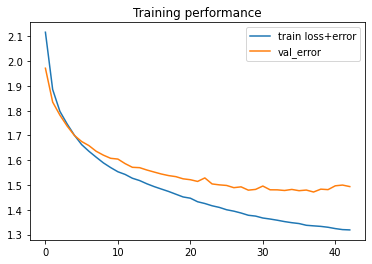

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

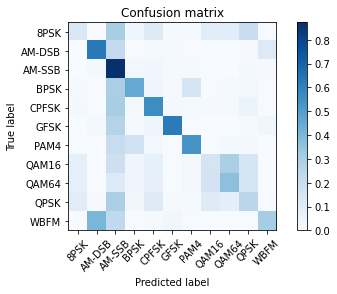

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09134906231094979


Overall Accuracy:  0.09121111446692842


Overall Accuracy:  0.09546682677874511


Overall Accuracy:  0.1170308290930859


Overall Accuracy:  0.1428996725215838


Overall Accuracy:  0.17113276492082827


Overall Accuracy:  0.26860254083484575


Overall Accuracy:  0.3628076572470374


Overall Accuracy:  0.4320168827253542


Overall Accuracy:  0.5702982349360926


Overall Accuracy:  0.648297213622291


Overall Accuracy:  0.677001806140879


Overall Accuracy:  0.6575851393188854


Overall Accuracy:  0.6556271082490034


Overall Accuracy:  0.6577572964669739


Overall Accuracy:  0.6375453446191052


Overall Accuracy:  0.6512898330804249


Overall Accuracy:  0.6449404761904762


Overall Accuracy:  0.6599579453289276


Overall Accuracy:  0.6507016473459426


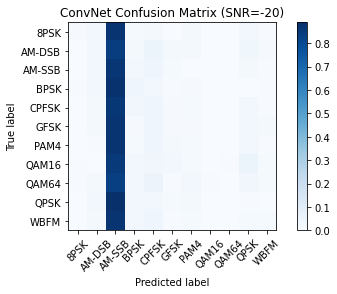

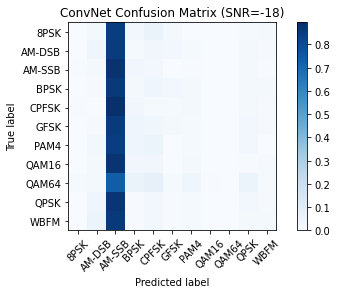

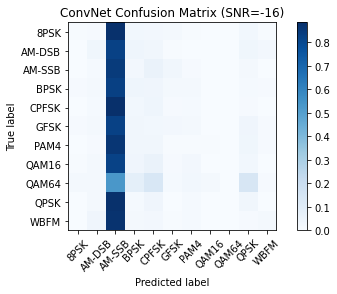

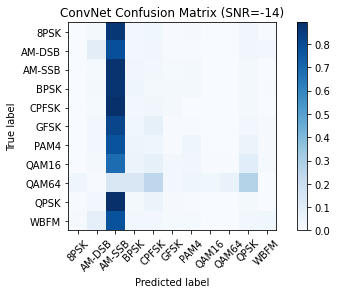

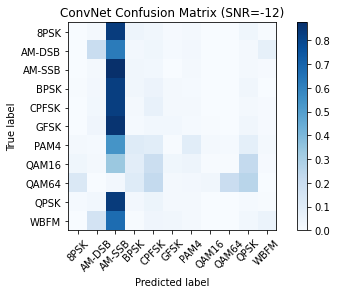

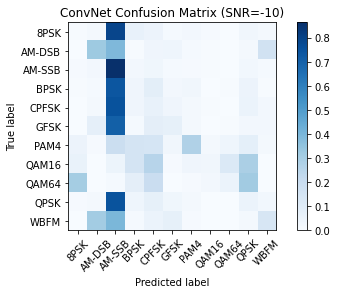

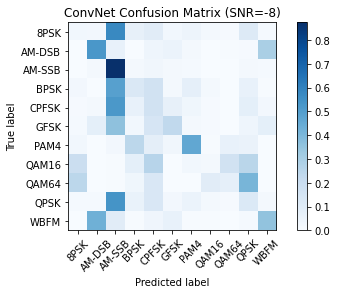

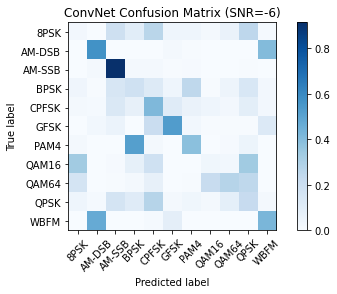

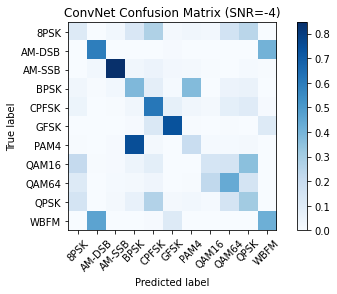

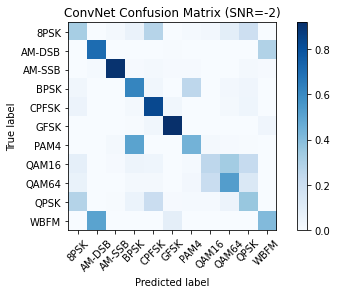

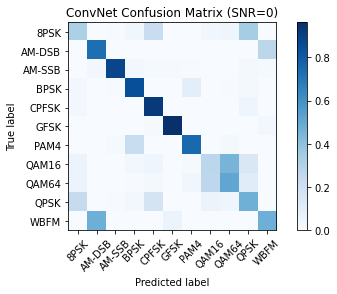

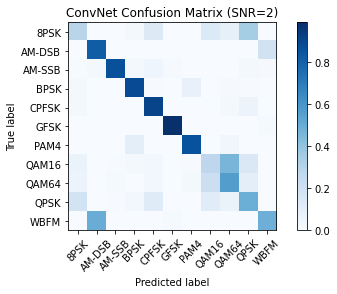

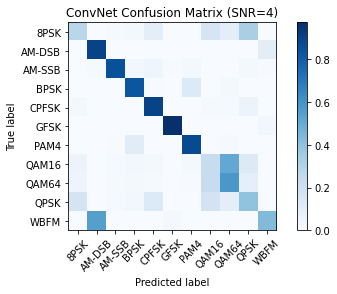

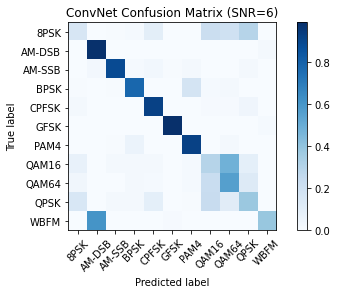

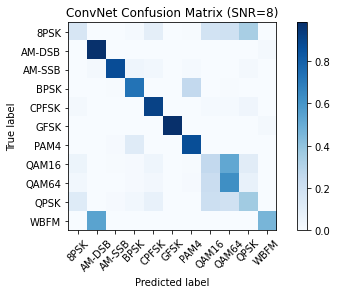

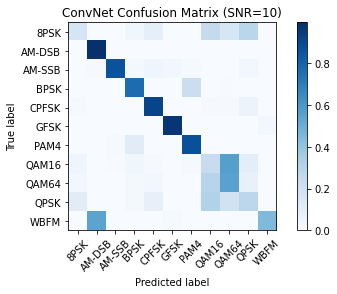

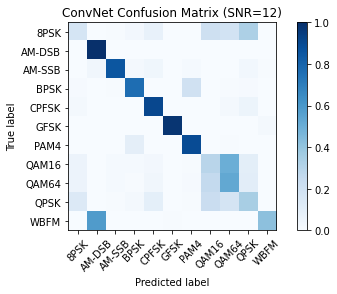

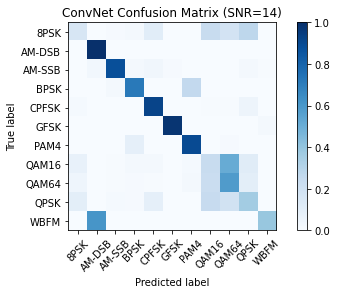

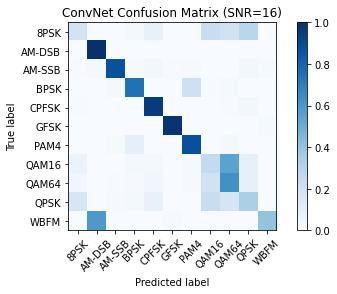

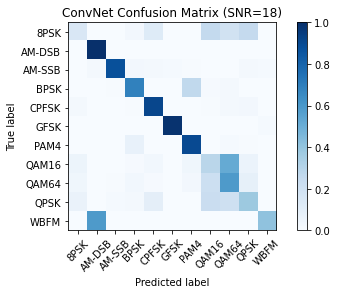

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,9,11,14,17,26,36,43,57,64,67,65,65,65,63,65,64,65,65


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

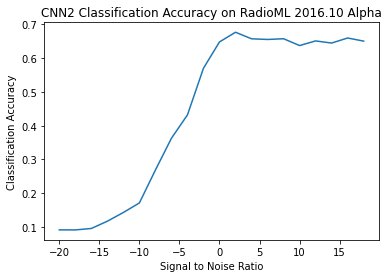

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")